#Unmasking Deepfakes: How a Custom CNN Exposes AI-Generated Faces

##Authored by Edric Ma



---



---



#OVERVIEW

In a society where it is getting increasingly difficult to identify real images from fake, there needs to be effective ways to counter this reality. Deepfake technology has become extremely powerful, often tricking the human eye at first glance and sometimes even upon further inspection. Human faces generated by AI can lead to spreading of fake news, misidentification of individuals, or even criminal activity. If the technology for something so dangerous has become so powerful, isn't it just as important to utilize technology to help us identify real and fake faces?

In this research notebook, I attempt to create a custom convolutional neural network (CNN) that can identify whether an image is real or AI generated at a relatively high accuracy.

Before we get to the custom CNN, we will do some basic background research, look into our dataset, and prepare our data for our models.

#BACKGROUND RESEARCH



##Generative Adversarial Network (GAN)

To understand the goal of our custom CNN, it would be valuable to understand what GANs are attempting to do to make the most realistic faces possible.

GANs are a class of AI models that generate realistic synthetic data (e.g., images, audio) by pitting two neural networks against each other:

Generator: Creates fake data from random noise.

Discriminator: Tries to distinguish fake data from real data.

How They Work:

The generator improves by trying to fool the discriminator. The discriminator improves by accurately detecting fakes.Through this adversarial training, the generator eventually produces highly realistic outputs.

It is essentially a competitive "game" where both networks improve until fakes are indistinguishable from real data. This is the goal of GANs.

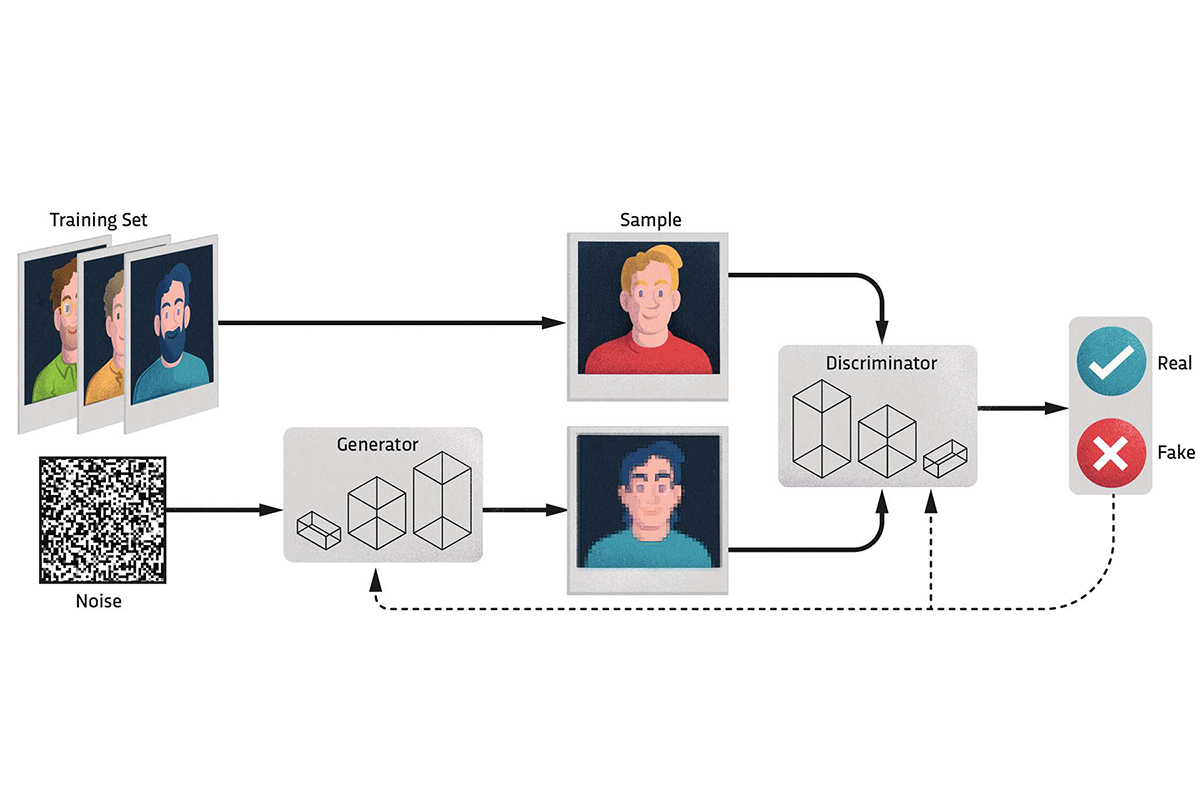

Source: https://www.sciencefocus.com/future-technology/how-do-machine-learning-gans-work

##Convolutional Neural Network (CNN)

CNNs are deep learning models designed for processing grid-like data (e.g., images, videos). They automatically learn spatial hierarchies of features through three key operations:

Convolutional Layers: Apply filters to detect local patterns (edges, textures).

Pooling Layers: Reduce dimensionality (e.g., max-pooling retains dominant features).

Fully Connected Layers: Classify features (e.g., identify objects).

How They Work:

Hierarchical Feature Learning: Early layers detect simple patterns (edges), deeper layers combine them into complex structures (shapes, objects).

Parameter Sharing: Filters scan the entire input, making CNNs efficient for spatial data.

##Technology Limitations



A large feature of this project is to explore ways to attack a highly complicated dataset with very nuanced differences between classes with limited and highly accessible technology/hardware. I am running this entirely using a Google Colab Notebook (CPU ONLY) on a MacBook Air (Apple M2 chip) 8GB memory. These specifications and applications are relatively standard and accessible, but can often be considered to be less than ideal for a complex deep learning project.

Throughout the notebook, I will make special note of certain decisions that have been made to accomodate these technology restrictions. They will be important to pay attention to if you would like to replicate this in a relatively efficient and accurate way.

#DATA INFORMATION & PREPARATION

##About the dataset

The dataset is called [140k Real and Fake Faces](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces/data) and it is taken from Kaggle. The data consists of 70k real faces (from Flickr) and 70k fake faces genrated by generative adversarial network (GAN).

In [1]:
!#Key imports for data extraction

import os
import kagglehub
import random
import matplotlib.pyplot as plt
import numpy as np

#Image tool imports
import cv2
from PIL import Image

#Deep learning imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Resizing

#Pretrained model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB5

Create a path to download the dataset to the notebook. Double check the Kaggle link for updates to the organization of data (change code below accordingly to ensure the correct folders are being accessed and downloaded).

In [6]:
#Download dataset and get correct path (download takes around 3 minutes)
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Dataset downloaded to:", path)

#Find the correct dataset directory structure
def find_dataset_path(base_path):
    #Look for the real_vs_fake directory
    for root, dirs, files in os.walk(base_path):
        if 'real-vs-fake' in dirs:
            return os.path.join(root, 'real-vs-fake')
    return base_path

100%|██████████| 3.75G/3.75G [01:38<00:00, 41.0MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2


The dataset is organized in the following manner:

50k real and 50k fake for training, 10k real and 10k fake for validation, 10k real and 10k fake for testing.

In [8]:
#Set correct paths
dataset_path = find_dataset_path(path)
print("Using dataset path:", dataset_path)

#Define paths for all datasets
train_real_dir = os.path.join(dataset_path, 'train/real/')
train_fake_dir = os.path.join(dataset_path, 'train/fake/')
valid_real_dir = os.path.join(dataset_path, 'valid/real/')
valid_fake_dir = os.path.join(dataset_path, 'valid/fake/')
test_real_dir = os.path.join(dataset_path, 'test/real/')
test_fake_dir = os.path.join(dataset_path, 'test/fake/')

Using dataset path: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake


Now we'll get a clean preview of mulitple samples of real and fake images from the dataset.

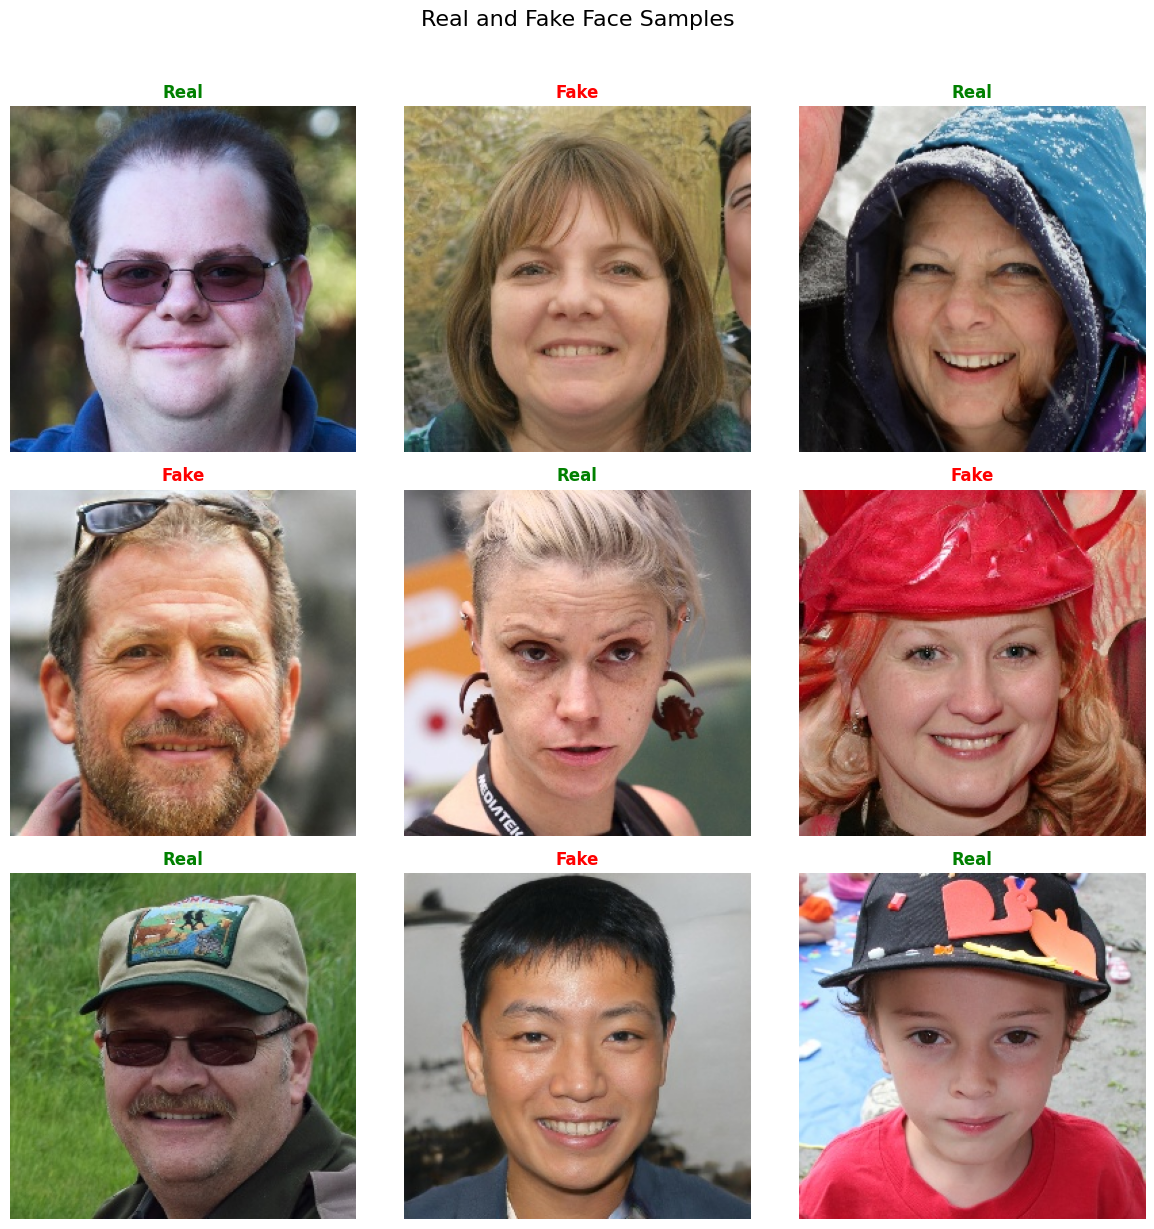

In [12]:
#Get samples (5 real and 4 fake since we start with real)
real_samples = random.sample(os.listdir(train_real_dir), 5)
fake_samples = random.sample(os.listdir(train_fake_dir), 4)

#Create the plot
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)

    #Alternate starting with real (positions 0,2,4,6,8)
    if i % 2 == 0:
        img_path = os.path.join(train_real_dir, real_samples[i//2])
        label, color = "Real", "green"
    else:
        img_path = os.path.join(train_fake_dir, fake_samples[i//2])
        label, color = "Fake", "red"

    try:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(label, color=color, fontweight='bold')
        plt.axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {str(e)}")
        plt.title("Image Error", color='black')

plt.suptitle("Real and Fake Face Samples", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Just looking at these sample images, if it weren't for the labels, I would have trouble identifying real from fake images.

#TESTING ON SUBSETS

##Data Preparation (Small Batch)



To save time on model training, we will conduct most of our CNN building and hyperparameter tuning on a subset of 10k real and 10k fake images. This will save us a great deal of time as using the entire dataset each time could take days to run. Although it may not be 100% indicative of how well the model would perform with the entire dataset at its disposal, it will give us a good idea of whether we are trended in the right direction.

The following data preparation section is replicated for each model with some minor changes to optimize that respective model.

The preprocessing pipeline's purpose is to prepare image data for machine learning by standardizing size and pixel values while optimizing performance.

In [7]:
# 1. PREPROCESSING PIPELINE
def preprocess_image(path, target_size=(128,128)):
    """Load and preprocess single image"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img / 255.0  # Normalize to [0,1]
    return img

def create_dataset(image_paths, labels, batch_size=32):
    """Create TensorFlow Dataset"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y),
                         num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


This section takes 10,000 samples from each class and sets the training validation splits for the model.

In [8]:
# 2. DATA PREPARATION
#Get 10k samples from each class
real_samples = random.sample(os.listdir(train_real_dir), 10000)
fake_samples = random.sample(os.listdir(train_fake_dir), 10000)

#Create paths and labels
real_paths = [os.path.join(train_real_dir, f) for f in real_samples]
fake_paths = [os.path.join(train_fake_dir, f) for f in fake_samples]
X_paths = real_paths + fake_paths
y = [1]*10000 + [0]*10000  # 1=real, 0=fake

#Train/val split (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_paths, y, test_size=0.2, stratify=y)

#Create datasets
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

Data augmentation is a key step that helps us artificially expand the training dataset by applying random transformations.

What It Does:

*   Random horizontal flips, mirrors images left-right (50% chance)
*   Random rotations, rotates images up to 10% of a full circle (±36 degrees)
*   Random zoom, zooms in/out by up to 10%

Why is data augmentation so crucial?

*   Fights overfitting, exposes the model to more variations of the same image and prevents memorization of exact training examples
*   Improves generalization, helps the model recognize objects in different orientations/zooms and mimics real-world scenarios (e.g., photos taken from angles)
*   Effectively increases dataset size, 1 original image → Many augmented versions

In [9]:
# 3. DATA AUGMENTATION
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

##CNN Architecture (Small Batch)

More specific decision making for each layer can be found in the CNN ARCHITECTURE (FULL DATASET) section.

In [10]:
# 4. CNN MODEL
model = models.Sequential([
    layers.Input(shape=(128,128,3)),
    augmentation,

    # Feature extraction
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Classification head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

Features of the following block of code:

1. Adam optimizer - Efficient gradient descent with learning rate 1e-4 for stable training.

2. Binary crossentropy loss - Standard for true/fake classification tasks.

3. Tracked metrics:
*   Accuracy - Overall correct prediction rate
*   AUC - Measures model's ranking ability (better than accuracy for imbalanced data)


4. Early stopping - Halts training if no improvement after 5 epochs to prevent overfitting.

5. ReduceLROnPlateau - Automatically halves learning rate if stagnation occurs for 2 epochs.

6. Restore best weights - Keeps the model version with peak validation performance.



In [11]:
# 5. TRAINING SETUP
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

# 6. TRAINING
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.5934 - auc: 0.6211 - loss: 0.8188 - val_accuracy: 0.5828 - val_auc: 0.7288 - val_loss: 0.7612 - learning_rate: 1.0000e-04
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.6648 - auc: 0.7217 - loss: 0.6175 - val_accuracy: 0.7075 - val_auc: 0.7827 - val_loss: 0.5843 - learning_rate: 1.0000e-04
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.6835 - auc: 0.7536 - loss: 0.5882 - val_accuracy: 0.7132 - val_auc: 0.7909 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.7121 - auc: 0.7827 - loss: 0.5627 - val_accuracy: 0.7195 - val_auc: 0.8139 - val_loss: 0.5486 - learning_rate: 1.0000e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.7250 - auc: 0.7965 - loss: 0.5470 - val_accuracy: 0.7570 - val_auc: 0.8371 - val_loss: 0.5006 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - 

The performance and speed are both relatively acceptable running on a CPU. Nearly 80% validation accuracy on only 10k images from each class and 10 epochs shows promise in this CNN build. There is potential for much higher accuracy if it is given more data to train on.

##Pre-trained CNN (EfficientNetB0 on small batch)

In this section we will utilize EfficientNetB0 to see how it performs on the subset of our data.

EfficientNetB0 is a pre-trained convolutional neural network (CNN) designed for high accuracy with minimal computational cost, while custom CNNs are manually designed architectures tailored for specific tasks. Here’s how they differ:

1. Architecture & Scaling
*   EfficientNetB0: Uses compound scaling (optimized depth/width/resolution) for efficiency. It’s part of the EfficientNet family (B0-B7), balancing speed and accuracy.
*   Custom CNN: Manually tuned layers (e.g., arbitrary Conv2D, pooling stacks) with no systematic scaling.



2. Pre-Trained Weights

*   EfficientNetB0: Pre-trained on ImageNet, enabling transfer learning (faster convergence with less data).
*   Custom CNN: Starts from scratch (random weights), requiring more data/training time.



3. Computational Efficiency
*   EfficientNetB0: Optimized for FLOPs/parameters (e.g., uses MBConv blocks with squeeze-and-excitation).
*   Custom CNN: May waste resources on redundant filters or suboptimal layer designs.

4. Use Cases
*   EfficientNetB0: Best for quick deployment with limited data (e.g., medical imaging, mobile apps).
*   Custom CNN: Flexible for research or unique tasks (e.g., custom input sizes, experimental layers).






In [21]:
# 3. EFFICIENTNET MODEL
def build_efficientnet():
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        input_shape=(128, 128, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Freeze base model
    base_model.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_efficientnet()
model.summary()

# 4. TRAINING SETUP
callbacks = [
    callbacks.ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss'),
    callbacks.ModelCheckpoint('best_effnet.h5', save_best_only=True)
]

# 5. TRAINING
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5039 - auc: 0.5014 - loss: 0.7065

500/500 ━━━━━━━━━━━━━━━━━━━━ 292s 567ms/step - accuracy: 0.5039 - auc: 0.5014 - loss: 0.7065 - val_accuracy: 0.5000 - val_auc: 0.4990 - val_loss: 0.6997 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5027 - auc: 0.5027 - loss: 0.7020

500/500 ━━━━━━━━━━━━━━━━━━━━ 318s 561ms/step - accuracy: 0.5026 - auc: 0.5027 - loss: 0.7020 - val_accuracy: 0.5000 - val_auc: 0.5005 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5013 - auc: 0.4975 - loss: 0.7015

500/500 ━━━━━━━━━━━━━━━━━━━━ 273s 546ms/step - accuracy: 0.5013 - auc: 0.4975 - loss: 0.7015 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 271s 542ms/step - accuracy: 0.5071 - auc: 0.5043 - loss: 0.6995 - val_accuracy: 0.5000 - val_auc: 0.4997 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 320s 539ms/step - accuracy: 0.4983 - auc: 0.4899 - loss: 0.7023 - val_accuracy: 0.5000 - val_auc: 0.5005 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5006 - auc: 0.4997 - loss: 0.6984

500/500 ━━━━━━━━━━━━━━━━━━━━ 237s 474ms/step - accuracy: 0.5006 - auc: 0.4997 - loss: 0.6984 - val_accuracy: 0.5000 - val_auc: 0.4997 - val_loss: 0.6935 - learning_rate: 5.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 305s 561ms/step - accuracy: 0.4990 - auc: 0.4913 - loss: 0.6987 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6936 - learning_rate: 5.0000e-04
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4977 - auc: 0.5034 - loss: 0.6969

500/500 ━━━━━━━━━━━━━━━━━━━━ 318s 553ms/step - accuracy: 0.4977 - auc: 0.5034 - loss: 0.6969 - val_accuracy: 0.5000 - val_auc: 0.5173 - val_loss: 0.6935 - learning_rate: 5.0000e-04
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 317s 544ms/step - accuracy: 0.5029 - auc: 0.4956 - loss: 0.6971 - val_accuracy: 0.5000 - val_auc: 0.5040 - val_loss: 0.6937 - learning_rate: 2.5000e-04
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 283s 566ms/step - accuracy: 0.5051 - auc: 0.5024 - loss: 0.6961 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6936 - learning_rate: 2.5000e-04


EfficientNetB0 seems to struggle heavily with capturing the nuances of the dataset enough to accurately decipher real from fake. Although it was two times faster than the custom CNN previously built, the validation accuracy essentially did not increase or decrease the entire 10 epochs.

This may be due to the fact that EfficientNetB0 is trained on ImageNet, which includes more object oriented images. It helps with object-oriented classification tasks, but struggles with facial features. It will naturally have a very hard time detecting small irregularities in facial features.

##Pre-trained CNN V2 (EfficientNetB5 on small batch)

Due to the poor performance of EfficientNetB0, I wanted to use EfficientNetB5 on the subset to see if there is improvement in the accuracy.

EfficientNetB5 is meant to have a better balance between accuracy and speed. It tends to perform better with lower resolution photos 224x224 < data < 300x300.

In [ ]:
from tensorflow.keras.layers import Resizing

def build_efficientnet():
    base_model = EfficientNetB5(
        input_shape=(224, 224, 3),  #B5 requires ≥224x224 so we are going to resize below
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(128, 128, 3))
    #Add resizing layer
    x = Resizing(224, 224, interpolation='bicubic')(inputs)  #Upscale 128→224
    x = base_model(x, training=False)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_efficientnet()
model.summary()

#TRAINING SETUP (ADJUSTED FOR B5)
callbacks = [
    callbacks.ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss'),
    callbacks.ModelCheckpoint('best_effnet_b5.h5', save_best_only=True),
    callbacks.EarlyStopping(patience=3, restore_best_weights=True)  # Added for B5
]

#TRAINING
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,515,576 (108.78 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 28,513,527 (108.77 MB)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5019 - auc: 0.4995 - loss: 0.7057

500/500 ━━━━━━━━━━━━━━━━━━━━ 3376s 7s/step - accuracy: 0.5019 - auc: 0.4996 - loss: 0.7057 - val_accuracy: 0.5098 - val_auc: 0.5651 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4939 - auc: 0.4974 - loss: 0.7050

500/500 ━━━━━━━━━━━━━━━━━━━━ 3187s 6s/step - accuracy: 0.4939 - auc: 0.4974 - loss: 0.7050 - val_accuracy: 0.5318 - val_auc: 0.5674 - val_loss: 0.6909 - learning_rate: 1.0000e-04
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5191 - auc: 0.5209 - loss: 0.6993

500/500 ━━━━━━━━━━━━━━━━━━━━ 3073s 6s/step - accuracy: 0.5191 - auc: 0.5209 - loss: 0.6993 - val_accuracy: 0.5297 - val_auc: 0.5700 - val_loss: 0.6908 - learning_rate: 1.0000e-04
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5078 - auc: 0.5105 - loss: 0.7005

500/500 ━━━━━━━━━━━━━━━━━━━━ 3220s 6s/step - accuracy: 0.5078 - auc: 0.5105 - loss: 0.7005 - val_accuracy: 0.5318 - val_auc: 0.5661 - val_loss: 0.6904 - learning_rate: 1.0000e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5144 - auc: 0.5190 - loss: 0.6991

500/500 ━━━━━━━━━━━━━━━━━━━━ 3193s 6s/step - accuracy: 0.5144 - auc: 0.5190 - loss: 0.6991 - val_accuracy: 0.5368 - val_auc: 0.5679 - val_loss: 0.6897 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5131 - auc: 0.5183 - loss: 0.6990

500/500 ━━━━━━━━━━━━━━━━━━━━ 3420s 7s/step - accuracy: 0.5131 - auc: 0.5183 - loss: 0.6990 - val_accuracy: 0.5395 - val_auc: 0.5673 - val_loss: 0.6895 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5079 - auc: 0.5176 - loss: 0.6983

500/500 ━━━━━━━━━━━━━━━━━━━━ 3214s 6s/step - accuracy: 0.5079 - auc: 0.5176 - loss: 0.6983 - val_accuracy: 0.5368 - val_auc: 0.5690 - val_loss: 0.6892 - learning_rate: 1.0000e-04
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3307s 7s/step - accuracy: 0.5221 - auc: 0.5266 - loss: 0.6964 - val_accuracy: 0.5370 - val_auc: 0.5693 - val_loss: 0.6893 - learning_rate: 1.0000e-04
Epoch 9/10
385/500 ━━━━━━━━━━━━━━━━━━━━ 9:48 5s/step - accuracy: 0.5138 - auc: 0.5158 - loss: 0.6987

This helps us close the EfficientNet chapter in our research. It is clear that EfficientNet is not suitable for our dataset, and is actually quite slow as well.

#CUSTOM CNN DATA PREPARATION (FULL DATASET)

Standard data preparation procedure, but this time with the entire dataset of 140k images.

*Scaling images to 128x128 is one of the accomodations being made for a less powerful system to lower training time.

In [9]:
# 1. PREPROCESSING PIPELINE
def preprocess_image(path, target_size=(128,128)):
    """Load and preprocess single image"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img / 255.0  #Normalize to [0,1]
    return img

def create_dataset(image_paths, labels, batch_size=32, shuffle=True):
    """Create TensorFlow Dataset"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y),
                         num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# 2. DATA PREPARATION
#Get all samples from each directory
train_real_samples = os.listdir(train_real_dir)
train_fake_samples = os.listdir(train_fake_dir)
valid_real_samples = os.listdir(valid_real_dir)
valid_fake_samples = os.listdir(valid_fake_dir)
test_real_samples = os.listdir(test_real_dir)
test_fake_samples = os.listdir(test_fake_dir)

#Create paths and labels for each dataset
#Training data (50k each)
train_real_paths = [os.path.join(train_real_dir, f) for f in train_real_samples]
train_fake_paths = [os.path.join(train_fake_dir, f) for f in train_fake_samples]
X_train_paths = train_real_paths + train_fake_paths
y_train = [1]*len(train_real_paths) + [0]*len(train_fake_paths)

#Validation data (10k each)
valid_real_paths = [os.path.join(valid_real_dir, f) for f in valid_real_samples]
valid_fake_paths = [os.path.join(valid_fake_dir, f) for f in valid_fake_samples]
X_val_paths = valid_real_paths + valid_fake_paths
y_val = [1]*len(valid_real_paths) + [0]*len(valid_fake_paths)

#Test data (10k each)
test_real_paths = [os.path.join(test_real_dir, f) for f in test_real_samples]
test_fake_paths = [os.path.join(test_fake_dir, f) for f in test_fake_samples]
X_test_paths = test_real_paths + test_fake_paths
y_test = [1]*len(test_real_paths) + [0]*len(test_fake_paths)

#Create datasets
train_ds = create_dataset(X_train_paths, y_train)
val_ds = create_dataset(X_val_paths, y_val, shuffle=False)
test_ds = create_dataset(X_test_paths, y_test, shuffle=False)

# 3. DATA AUGMENTATION
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#CUSTOM CNN ARCHITECTURE BUILDING

Some other model builds were tested on another notebook which resulted in either a decrease in accuracy or major increase in computational cost compared to the model below. Additionally, due to the success of the original custom CNN on the subset, no major change has been made to the structure of the CNN. The structure and the decision behind them are as follows:

1. Input Layer (shape=(128,128,3))
* What it does: Accepts 128x128 RGB images

* Why it works:
  *  Balanced resolution to capture facial details while being computationally efficient
  * Fake-face artifacts (e.g., strange textures around eyes/mouth) remain visible at this resolution

2. Convolutional Layers

  A. Conv2D(32/64/128, 3, ...)
    * Filter Numbers (32→64→128):
      * Progressively extracts:
        * Low-level features (edges, skin textures - Layer 1)
        * Mid-level features (facial parts - Layer 2)
        * High-level features (face structure anomalies - Layer 3)

    * Kernel Size (3x3):
      * Optimal for capturing small artifacts (e.g., irregular pores in fake faces)

  B. BatchNormalization()
    * Why critical:
      * Stabilizes training when detecting subtle differences (e.g., slight color inconsistencies in fakes)
      * Allows faster convergence with higher learning rates

  C. MaxPooling2D()
    * Role:
      * Reduces spatial dimensions while preserving dominant features
      * Helps model focus on structural inconsistencies (e.g., asymmetric eyes in deepfakes)

3. Classification Head
  
  A. Dense(256)
    * Why 256 units:
      * Enough capacity to combine facial features without overfitting
      * Learns relationships like "unnatural shadow + perfect symmetry = fake"

  B. Dropout(0.5)
    * Purpose:
      * Randomly disables 50% of neurons to prevent reliance on single artifacts
      * Crucial because fake-face generators often leave localized tells

  C. Dense(1, 'sigmoid')
    * Design choice:
      * Binary output (0=fake, 1=real) with probabilistic confidence
      * Sigmoid squashes values to 0-1 range for clear classification

In [10]:
# 4. CNN MODEL
model = models.Sequential([
    layers.Input(shape=(128,128,3)),
    augmentation,

    #Feature extraction
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #Classification head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

The code below creates a visualization of the model. It shows the change our data goes through as it goes through the layers.

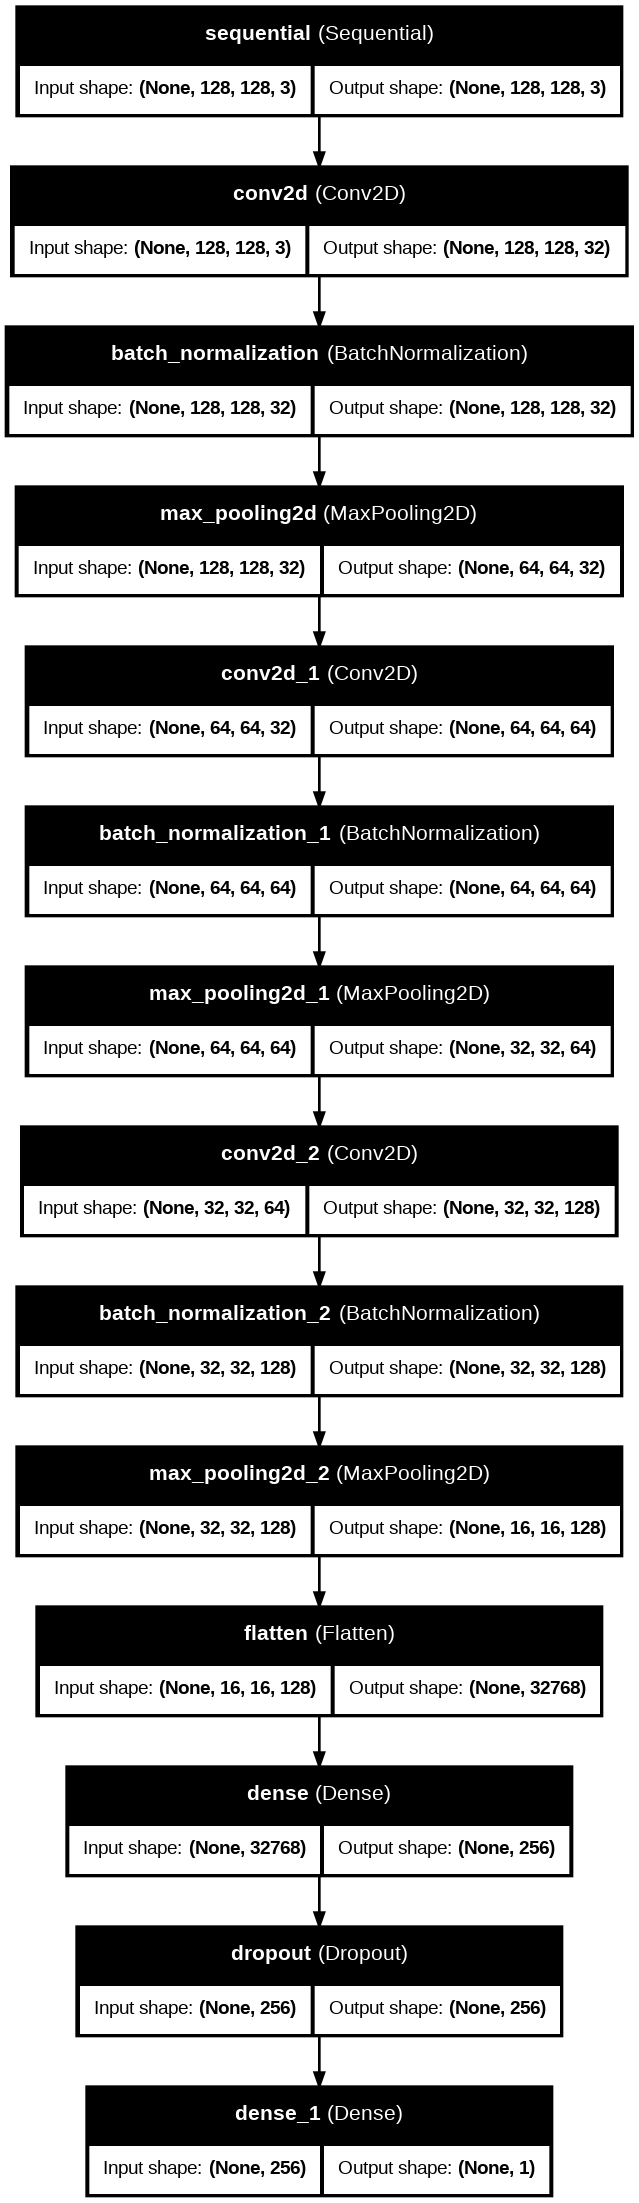

In [14]:
from tensorflow.keras.utils import plot_model

#Generate diagram
plot_model(
    model,
    to_file='cnn_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # Top-to-bottom layout
    dpi=96
)

#Display in notebook
from IPython.display import Image
Image('cnn_architecture.png')

**CRUCIAL STEP:**

**This step is critical because Google Colab's runtime can disconnect unexpectedly, which would permanently erase all training progress unless checkpoints are saved externally.** By mounting Google Drive and saving checkpoints there, you ensure your model's weights are preserved even if the session crashes or times out, allowing you to resume training exactly where you left off.

Think of it like an emergency backup—without it, hours of training could vanish in an instant.



In [ ]:
from google.colab import drive

#Mount Google Drive (to save checkpoints persistently)
drive.mount('/content/drive')

#Define checkpoint path (save to Google Drive)
checkpoint_dir = '/content/drive/MyDrive/Colab_Models/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.weights.h5')

In [ ]:
# 5. TRAINING SETUP
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#Callbacks: EarlyStopping + ReduceLROnPlateau + ModelCheckpoint
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',           # Save based on validation val_accuracy
        mode='max',
        save_best_only=True,         #Only save the best model
        save_weights_only=True,      #Save only weights (smaller file)
        verbose=1                   #Print messages when saving
    )
]

In [ ]:
# 6. TRAINING
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6477 - auc: 0.6982 - loss: 0.6676
Epoch 1: val_accuracy improved from -inf to 0.74820, saving model to /content/drive/MyDrive/Colab_Models/model_checkpoint.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6671s 2s/step - accuracy: 0.6478 - auc: 0.6982 - loss: 0.6675 - val_accuracy: 0.7482 - val_auc: 0.8455 - val_loss: 0.5100 - learning_rate: 1.0000e-04
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7537 - auc: 0.8318 - loss: 0.5059
Epoch 2: val_accuracy improved from 0.74820 to 0.81720, saving model to /content/drive/MyDrive/Colab_Models/model_checkpoint.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6395s 2s/step - accuracy: 0.7537 - auc: 0.8318 - loss: 0.5059 - val_accuracy: 0.8172 - val_auc: 0.8999 - val_loss: 0.4038 - learning_rate: 1.0000e-04
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━

Previous runtime disconnected after 6 completed epochs. Load in the previously completed epochs from your Google Drive and change the initial epoch variable in the model.fit section to 6.

In [ ]:
from google.colab import drive

#Mount Google Drive (to save checkpoints persistently)
drive.mount('/content/drive')

#Define checkpoint path (save to Google Drive)
checkpoint_dir = '/content/drive/MyDrive/Colab_Models/'
os.makedirs(checkpoint_dir, exist_ok=True)  # Create dir if it doesn't exist
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.weights.h5')

#5. TRAINING SETUP
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#Callbacks: EarlyStopping + ReduceLROnPlateau + ModelCheckpoint
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

model.load_weights(checkpoint_path)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=6,  # Start from epoch 6 (the last fully completed epoch before timeout)
    callbacks=callbacks
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 7/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8725 - auc: 0.9434 - loss: 0.3047
Epoch 7: val_accuracy improved from -inf to 0.88355, saving model to /content/drive/MyDrive/Colab_Models/model_checkpoint.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7069s 2s/step - accuracy: 0.8725 - auc: 0.9434 - loss: 0.3047 - val_accuracy: 0.8835 - val_auc: 0.9541 - val_loss: 0.2773 - learning_rate: 1.0000e-04
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8869 - auc: 0.9547 - loss: 0.2726
Epoch 8: val_accuracy improved from 0.88355 to 0.89355, saving model to /content/drive/MyDrive/Colab_Models/model_checkpoint.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7184s 2s/step - accuracy: 0.8869 - auc: 0.9547 - loss: 0.2726 - val_accuracy: 0.8935 - val_auc: 0.9603 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 9/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8941 - auc: 0.9600 - loss: 0.2565
Epoch 9: val_accuracy did not improve from 0.89355
3125/3125 ━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

checkpoint_dir = '/content/drive/MyDrive/Colab_Models/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.weights.h5')

# 5. TRAINING SETUP
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
    callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

model.load_weights(checkpoint_path)  #Load best saved weights

history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=13,
    callbacks=callbacks
)


Mounted at /content/drive
Epoch 14/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9074 - auc: 0.9689 - loss: 0.2256
Epoch 14: val_accuracy improved from -inf to 0.91445, saving model to /content/drive/MyDrive/Colab_Models/model_checkpoint.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3678s 1s/step - accuracy: 0.9074 - auc: 0.9689 - loss: 0.2256 - val_accuracy: 0.9144 - val_auc: 0.9735 - val_loss: 0.2109 - learning_rate: 1.0000e-04
Epoch 15/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9160 - auc: 0.9727 - loss: 0.2111
Epoch 15: val_accuracy improved from 0.91445 to 0.92170, saving model to /content/drive/MyDrive/Colab_Models/model_checkpoint.weights.h5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3704s 1s/step - accuracy: 0.9160 - auc: 0.9727 - loss: 0.2111 - val_accuracy: 0.9217 - val_auc: 0.9759 - val_loss: 0.1982 - learning_rate: 1.0000e-04
Epoch 16/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9223 - auc: 0.9762 - loss: 0.1962
Epoch 16: val_accuracy did not improve from 0.92170
3125/3125 ━━━━━━━━━━━

After 20.5 hours of training and three separate runtimes, we managed to achieve a peak validation accuracy of 93.44%.

#CNN ARCHITECTURE TRAINING AND TEST RESULTS

Unfortunately, because of the nature of runtime disconnects interupting our training, we need to manually extract our statistic reports for each epoch.

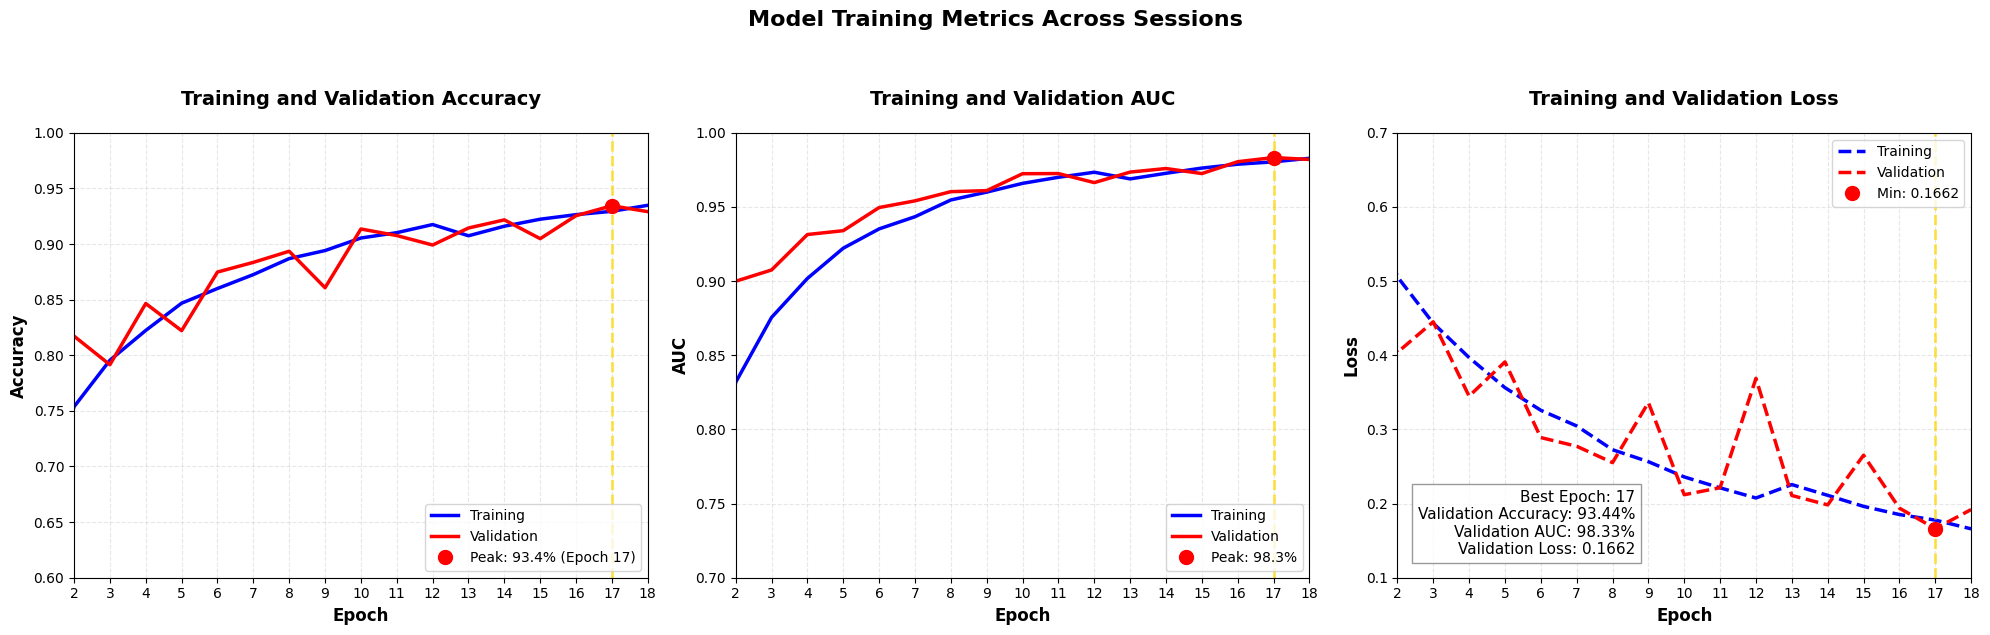

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#Extracted metrics from training logs
history = {
    'accuracy': [0.6478, 0.7537, 0.7955, 0.8223, 0.8468, 0.8600, 0.8725, 0.8869, 0.8941, 0.9054,
                 0.9102, 0.9175, 0.9074, 0.9160, 0.9223, 0.9264, 0.9294, 0.9348],
    'val_accuracy': [0.7482, 0.8172, 0.7915, 0.8465, 0.8221, 0.8748, 0.8835, 0.8935, 0.8607,
                    0.9135, 0.9076, 0.8991, 0.9144, 0.9217, 0.9048, 0.9255, 0.9344, 0.9291],
    'auc': [0.6982, 0.8318, 0.8755, 0.9018, 0.9222, 0.9352, 0.9434, 0.9547, 0.9600,
            0.9659, 0.9700, 0.9734, 0.9689, 0.9727, 0.9762, 0.9788, 0.9804, 0.9828],
    'val_auc': [0.8455, 0.8999, 0.9075, 0.9314, 0.9340, 0.9496, 0.9541, 0.9603, 0.9610,
               0.9724, 0.9725, 0.9664, 0.9735, 0.9759, 0.9725, 0.9805, 0.9833, 0.9820],
    'loss': [0.6675, 0.5059, 0.4432, 0.3969, 0.3563, 0.3258, 0.3047, 0.2726, 0.2565,
             0.2359, 0.2212, 0.2075, 0.2256, 0.2111, 0.1962, 0.1852, 0.1777, 0.1659],
    'val_loss': [0.5100, 0.4038, 0.4451, 0.3448, 0.3910, 0.2890, 0.2773, 0.2552, 0.3362,
                0.2119, 0.2214, 0.3689, 0.2109, 0.1982, 0.2652, 0.1938, 0.1662, 0.1919]
}


#Create figure with 3 subplots
plt.figure(figsize=(20, 6))

#Find peak performance (using val_auc as primary metric)
peak_epoch = np.argmin(history['val_loss'])  # Using minimum loss for peak
peak_acc = history['val_accuracy'][peak_epoch]
peak_auc = history['val_auc'][peak_epoch]
peak_loss = history['val_loss'][peak_epoch]

# 1. Accuracy Plot
plt.subplot(1, 3, 1)


#Plot lines
plt.plot(history['accuracy'], 'b-', linewidth=2.5, label='Training')
plt.plot(history['val_accuracy'], 'r-', linewidth=2.5, label='Validation')

#Highlight peak
plt.axvline(x=peak_epoch, color='gold', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(peak_epoch, peak_acc, 'o', markersize=10, color='red',
         label=f'Peak: {peak_acc:.1%} (Epoch {peak_epoch+1})')

#Formatting
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.xticks(np.arange(0, 18, 1), np.arange(1, 19, 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0.6, 1.0)
plt.xlim(1, 17)
plt.legend(loc='lower right', fontsize=10)


# 2. AUC Plot
plt.subplot(1, 3, 2)

#Plot lines
plt.plot(history['auc'], 'b-', linewidth=2.5, label='Training')
plt.plot(history['val_auc'], 'r-', linewidth=2.5, label='Validation')

#Highlight peak
plt.axvline(x=peak_epoch, color='gold', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(peak_epoch, peak_auc, 'o', markersize=10, color='red',
         label=f'Peak: {peak_auc:.1%}')

#Formatting
plt.title('Training and Validation AUC', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('AUC', fontsize=12, fontweight='bold')
plt.xticks(np.arange(0, 18, 1), np.arange(1, 19, 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0.7, 1.0)
plt.xlim(1, 17)
plt.legend(loc='lower right', fontsize=10)


# 3. Loss Plot
plt.subplot(1, 3, 3)


#Plot lines (inverted colors for loss)
plt.plot(history['loss'], 'b--', linewidth=2.5, label='Training')
plt.plot(history['val_loss'], 'r--', linewidth=2.5, label='Validation')

#Highlight minimum loss
plt.axvline(x=peak_epoch, color='gold', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(peak_epoch, peak_loss, 'o', markersize=10, color='red',
         label=f'Min: {peak_loss:.4f}')

#Formatting
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.xticks(np.arange(0, 18, 1), np.arange(1, 19, 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0.1, 0.7)
plt.xlim(1, 17)
plt.legend(loc='upper right', fontsize=10)


#Final Touches
plt.suptitle('Model Training Metrics Across Sessions', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()

#Performance summary box
textstr = '\n'.join((
    f'Best Epoch: {peak_epoch+1}',
    f'Validation Accuracy: {peak_acc:.2%}',
    f'Validation AUC: {peak_auc:.2%}',
    f'Validation Loss: {peak_loss:.4f}'))

plt.gcf().text(0.82, 0.25, textstr, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
               fontsize=11, ha='right', va='top')

plt.show()

The model showed strong and consistent improvement, with training accuracy rising from 64.8% to 93.5% and validation accuracy peaking at 93.4%. The steady rise in AUC scores confirms the model learned meaningful patterns to distinguish authentic from synthetic faces.


In [ ]:
# Evaluation
print("\nEvaluating on test set:")
test_results = model.evaluate(test_ds)
print(f"Test Accuracy: {test_results[1]:.4f}, Test AUC: {test_results[2]:.4f}")

# Save final model
model.save(os.path.join(checkpoint_dir, 'densenet_final_model.h5'))


Evaluating on test set:
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 251ms/step - accuracy: 0.9261 - auc: 0.4922 - loss: 0.1895
Test Accuracy: 0.9311, Test AUC: 0.9816


Our model has achieved a 93.11% test accuracy.

#AI GENERATED FACE DETECTION TOOL

This will allow us to create a tool where users can upload a jpeg image, then the model will attempt to classify whether the image is real or fake. It will also provide a confidence score.

The model outputs a value between 0 (100% fake) and 1 (100% real)

The decision threshold is 0.5 (default for binary classification)

Confidence level > 0.5 → Predicted as REAL (with confidence %)'

Confidence level < 0.5 → Predicted as FAKE (with confidence %)


Mounted at /content/drive
✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saving aYmax6O3.jpg to aYmax6O3.jpg

Uploaded Image:


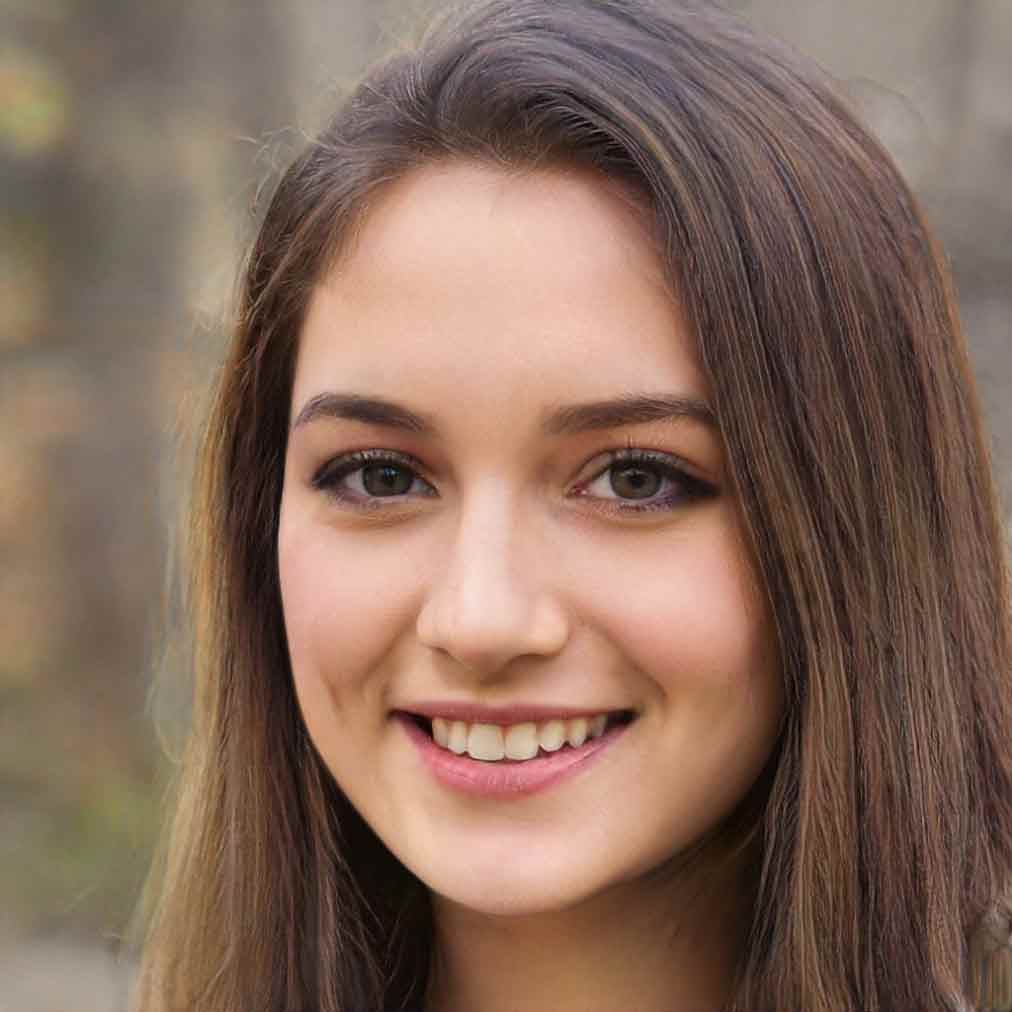


Prediction: FAKE (Confidence: 0.25%)


In [2]:
from google.colab import drive
from google.colab import files
from IPython.display import Image, display
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define paths
checkpoint_dir = '/content/drive/MyDrive/Colab_Models/'
model_path = os.path.join(checkpoint_dir, 'model_checkpoint.weights.h5')

# 3. Verify checkpoint exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model weights not found at {model_path}")

# 4. Rebuild model architecture with augmentation
def build_model():
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),
        augmentation,

        # Feature extraction
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        # Classification head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# 5. Build and load model
try:
    model = build_model()
    model.load_weights(model_path)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# 6. Prediction function (matches your 128x128 input size)
def predict_image(model, img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)[0][0]
    return "REAL" if prediction > 0.5 else "FAKE", float(prediction)

# 7. Test with uploaded image
uploaded = files.upload()
if not uploaded:
    print("No files uploaded!")
else:
    img_path = list(uploaded.keys())[0]
    print("\nUploaded Image:")
    display(Image(img_path, width=300))

    class_label, confidence = predict_image(model, img_path)
    print(f"\nPrediction: {class_label} (Confidence: {confidence:.2%})")

#CONCLUSION

After careful selection of CNN layers and meticulous hyperparameter tuning, a test accuracy of 93.1% was achieved by the custom CNN. It can somewhat reliably identify synthetic images of human faces. I believe there is still a great deal of room for improvement in terms of accuracy and efficiency of this model. This is a strong starting point for myself and other developers to build off of.

Even when 99.9% accuracy is achieved for this dataset, there will still be so much work to do. This very moment, a new GAN is being trained to fix the flaws of its predecessors. While, in parallel, a CNN detector evolves to catch those improved fakes. This is a technological arms race with no finish line. It would be a nightmare scenario if deepfake technologies developed to a point where detection models were simply unable detect them. This is why it is so crucial that researchers and developers continue to improve detection methods and models, and businesses invest in these counteractive measures to ensure society is protected from the damages of deepfake technology.

#APPENDIX

Dataset:

https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces/data


Images:

https://www.sciencefocus.com/future-technology/how-do-machine-learning-gans-work

Additional research:

https://aws.amazon.com/what-is/gan/

https://www.ibm.com/think/topics/convolutional-neural-networks
